This example emphasizes two scenarii not covered in the simple example:
- using charge passed over time data, which can be acquired when performing electrochemical measurements, and that can help improve the accuracy of the time constants obtained from the fit
- fitting when the concentration evolution over time experimental data only covers some of the species considered in the model

**TODO: comment each steps presented here**

### Kinetic model

$$\frac{d[HMF]}{dt} = -(k_{\textbf{1}1} + k_{\textbf{1}2} + k_{H\textbf{1}})[HMF]$$

$$\frac{d[DFF]}{dt} = k_{\textbf{1}1}[HMF] - (k_{\textbf{2}1} + k_{H\textbf{2}1})[DFF]$$

$$\frac{d[HMFCA]}{dt} = k_{\textbf{1}2}[HMF] - (k_{\textbf{2}2} + k_{H\textbf{2}2})[HMFCA]$$

$$\frac{d[FFCA]}{dt} = k_{\textbf{2}1}[DFF] + k_{\textbf{2}2}[HMFCA] - (k_{\textbf{3}} + k_{H\textbf{3}})[FFCA]$$

$$\frac{d[FDCA]}{dt} = k_{\textbf{3}}[FFCA] - k_{H\textbf{4}}[FDCA]$$

$$\frac{d[humins]}{dt} = k_{H\textbf{1}}[HMF] + k_{H\textbf{2}1}[DFF] + k_{H\textbf{2}2}[HMFCA]$$
$$+ k_{H\textbf{3}}[FFCA] + k_{H\textbf{4}}[FDCA] - k_{H^*}[humins]$$

$$\frac{d[humins^*]}{dt} = k_{H^*}[humins]$$

In [1]:
species_tracked = [
    "HMF", "DFF", "HMFCA", "FFCA", "FDCA"
]
species_untracked = [
    "H_HMF",  "H_DFF",  "H_HMFCA",  "H_FFCA",  "H_FDCA",
    "Hx_HMF", "Hx_DFF", "Hx_HMFCA", "Hx_FFCA", "Hx_FDCA"
]
species = species_tracked.copy()
species.extend(species_untracked)

In [2]:
def derivatives(y, t, p):

    """
    Calculates the derivatives from local values, used by scipy.integrate.solve_ivp
    """
    
    c = {s:y[i] for i, s in enumerate(species)}
    
    dc = dict()

    dc["HMF"]      =  - (p["k11"] + p["k12"] + p["kH1"])*c["HMF"]
    dc["DFF"]      = p["k11"]*c["HMF"]                       - (p["k21"] + p["kH21"])*c["DFF"]
    dc["HMFCA"]    = p["k12"]*c["HMF"]                       - (p["k22"] + p["kH22"])*c["HMFCA"]
    dc["FFCA"]     = p["k21"]*c["DFF"] + p["k22"]*c["HMFCA"] - (p["k3"] + p["kH3"])*c["FFCA"]
    dc["FDCA"]     = p["k3"]*c["FFCA"]                       - p["kH4"]*c["FDCA"]
    
    dc["H_HMF"]    = p["kH1"]*c["HMF"]    - p["kHx"]*c["H_HMF"]
    dc["H_DFF"]    = p["kH21"]*c["DFF"]   - p["kHx"]*c["H_DFF"]
    dc["H_HMFCA"]  = p["kH22"]*c["HMFCA"] - p["kHx"]*c["H_HMFCA"]
    dc["H_FFCA"]   = p["kH3"]*c["FFCA"]   - p["kHx"]*c["H_FFCA"]
    dc["H_FDCA"]   = p["kH4"]*c["FDCA"]   - p["kHx"]*c["H_FDCA"]

    dc["Hx_HMF"]   = p["kHx"]*c["H_HMF"]
    dc["Hx_DFF"]   = p["kHx"]*c["H_DFF"]
    dc["Hx_HMFCA"] = p["kHx"]*c["H_HMFCA"]
    dc["Hx_FFCA"]  = p["kHx"]*c["H_FFCA"]
    dc["Hx_FDCA"]  = p["kHx"]*c["H_FDCA"]
    
    dy = [dc[name] for name in species]

    return dy

$$Q = \frac{q}{N_A} \sum_i n_i [i]$$

In [3]:
import numpy as np
import scipy.constants as constants

def c_to_q(c):

    c_e = list()
    for i, s in enumerate(species):
        c_e.append(2*(i%5 + int(i/5))*c[:,i])

    c_e = np.sum(c_e, axis = 0) # uM
    c_e *= 1e-6 # M

    V = 100e-3 # L

    q = c_e*V*constants.N_A*constants.e # number of charge in coulombs

    return q

### Load concentrations and charge passed evolution over time

In [4]:
from chemical_kinetics import data_processing

folders = [f"data/run{i}/" for i in range(1,4)]
files_c = [f"{folder}Reaction Monitoring.csv" for folder in folders]
files_q = [f"{folder}Charge Passed.csv" for folder in folders]

ds = data_processing.Dataset(
    files_c = files_c,
    files_q = files_q,
    t_label = "Time [h]",
    c_label = r"Concentration [$\rm\mu$M]",
    q_label = "Charge passed [C]"
)

### Fitting

Define parameters

In [5]:
parameter_args = dict(value = 0.05, min = 0)
parameter_names = [
    "k11","k12","k21","k22","k3",
    "kH1","kH21","kH22","kH3","kH4",
    "kHx"
    ]
parameters = {name: parameter_args for name in parameter_names}

Define c0

In [6]:
c0 = {name: dict(vary = False) for name in species_tracked}

Define c0_untracked

In [7]:
from collections import OrderedDict
c0_untracked = OrderedDict({
    name: dict(value = 0, vary = False) for name in species_untracked
})

In [9]:
from chemical_kinetics import fit

fit.fit_dataset(
    dataset = ds,
    derivatives = derivatives,
    c_to_q = c_to_q,
    parameters = parameters,
    c0 = c0,
    c0_untracked = c0_untracked
)

Fit succeeded.


### Fit results

In [10]:
fit.print_result(ds)

,name,value,stderr,stderr/value %,init. val.,vary,min,max
0,k11,0.00554,0.000194,3.51,0.05,True,0.0,inf
1,k12,0.00181,5.24e-05,2.89,0.05,True,0.0,inf
2,k21,0.0649,0.00333,5.13,0.05,True,0.0,inf
3,k22,0.038,0.00303,7.98,0.05,True,0.0,inf
4,k3,0.00731,0.000395,5.41,0.05,True,0.0,inf
5,kH1,0.0302,0.000366,1.21,0.05,True,0.0,inf
6,kH21,0.0435,0.00659,15.1,0.05,True,0.0,inf
7,kH22,5.87e-06,0.00251,4.27e+04,0.05,True,0.0,inf
8,kH3,0.0545,0.00317,5.81,0.05,True,0.0,inf
9,kH4,0.0728,0.00594,8.17,0.05,True,0.0,inf


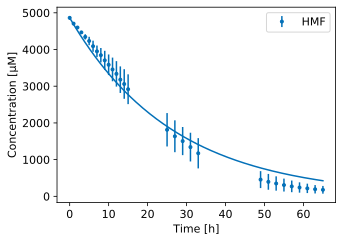

In [11]:
from chemical_kinetics import plot

plot.plot_c(ds, ["HMF"])

In [ ]:
plot.plot_c(ds, ["DFF", "HMFCA", "FFCA", "FDCA"])

In [ ]:
plot.plot_q(ds)